In [1]:
import glam
import pandas as pd
import numpy as np
import os.path

In [2]:
import matplotlib.pyplot as plt

from scipy.stats import invgauss
import seaborn as sns
import matplotlib.pyplot as plt
#plt.switch_backend('agg')
from scipy import stats
from scipy.stats.stats import pearsonr # Pearson's correlation
import statsmodels.api as sm

from sklearn import linear_model  # packages for the logistic regression function to plot the logistic regression 
from sklearn.linear_model import LogisticRegression # packages for the logistic regression function to plot the logistic regression 


#import warnings
#warnings.filterwarnings('ignore')

In [3]:
np.random.seed(23) # from random.org

In [4]:
# For rpy2

import rpy2

%load_ext rpy2.ipython
# Set up interface with R
# Make it easy to set and find values in a multi-index DF
idx = pd.IndexSlice

# Set up interface with R
%config InlineBackend.figure_format = 'retina'
import warnings
from rpy2.rinterface import RRuntimeWarning
warnings.filterwarnings("ignore", category=RRuntimeWarning)


In [5]:
# For MacMini proper running
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [6]:
%%R
library(lme4)
library(car)
library(optimx)
library(ggplot2)
library(MASS)
library(broom)
library(dplyr)
library(reshape2)
library(arm)
library(multcomp)
library(pbkrtest)

## Custom functions

In [7]:
def balance_evidence(value_tests, gaze_tests, parameters,boundary, error_weight, error_range,n_repeats):
    
    mean_rts_trials = np.zeros((value_tests.shape[0])) * np.nan
    choice_trials = np.zeros((value_tests.shape[0])) * np.nan
    DEv_trials = np.zeros((value_tests.shape[0])) * np.nan
    AbsDEv_trials = np.zeros((value_tests.shape[0])) * np.nan
    Ev_drifts_0_trials  = []
    Ev_drifts_1_trials = []

    n_trials, n_items = value_tests.shape

    running_idx_value = 0
    #we iterate for all the combinations of trials + gaze
    for trial in range(n_trials):
        
            # intialize the drifts
            evidence_drifts_0 = []
            evidence_drifts_1 = []

            #define value and gaze values for this particular trial
            value_trial =value_tests[trial]
            gaze_trial =gaze_tests[trial]
            
            Sim_value = value_trial
            Sim_gaze = gaze_trial
            
            Delta_E = np.zeros(n_repeats) * np.nan            
            AbsDelta_E = np.zeros(n_repeats) * np.nan
            rts = np.zeros(n_repeats) * np.nan
            choices = np.zeros(n_repeats) * np.nan
            trial_idx = np.zeros(n_repeats) * np.nan
            repeat_idx = np.zeros(n_repeats) * np.nan
            running_idx = 0
        
            for repeat in range(n_repeats):
                    

                    
                    Evi_0, Evi_1, choice, rt = glam.driftSim.simulate_trial_drift(parameters, value_trial, gaze_trial,
                                                boundary=boundary,
                                                error_weight=error_weight,
                                                error_range=error_range)
                    
                    Delta_E[running_idx] = Evi_1[-1] - Evi_0[-1]
                    AbsDelta_E[running_idx] = abs(Evi_0[-1] - Evi_1[-1])                        
                    rts[running_idx] = rt
                    choices[running_idx] = choice
                    trial_idx[running_idx] = trial
                    repeat_idx[running_idx] = repeat
                    # Add a new sequence of drift for this particular trial
                    evidence_drifts_0.append(Evi_0)
                    evidence_drifts_1.append(Evi_1)
                    
                    running_idx += 1
                    
               
            # Add the mean value for this parameters interation               
            mean_rts_trials [running_idx_value] = rts.mean()
            choice_trials [running_idx_value]= choices.mean() 
            DEv_trials [running_idx_value] = Delta_E.mean()
            AbsDEv_trials [running_idx_value]= AbsDelta_E.mean()
            Ev_drifts_0_trials.append(evidence_drifts_0)
            Ev_drifts_1_trials.append(evidence_drifts_1)
 
            running_idx_value += 1 

    return AbsDEv_trials,mean_rts_trials,Ev_drifts_0_trials,Ev_drifts_1_trials,choice_trials

In [8]:
def z_score1(data_all, part_def,z_score_var):
    z_matrix=[]
    z_matrix_aux=[]

    for i in (data_all[part_def].unique()):
        Choicedata = data_all.loc[data_all[part_def] == i]    
    
        pX_A= pd.to_numeric(Choicedata[z_score_var]) 
        pX_zA= (pX_A - np.mean(pX_A))/np.std(pX_A)

    
        z_matrix_aux= pX_zA.values
    
        for  j in range(len(z_matrix_aux)):    
            z_matrix.append(z_matrix_aux[j])
    return z_matrix

In [9]:
def correl_plot(data_all,x_variable, x_varlabel,y_variable,y_varlabel):

    f = plt.figure(figsize=(8, 8))
    sns.set(style='white', font_scale=1.8)
    ax = sns.regplot(data=data_all, x= x_variable, y=y_variable, fit_reg=False, ci=0, color='#000000', scatter_kws={'s':70})
    #sns.regplot(data=data_exp1, x='AbsDiffValue', y='Confidence', fit_reg=False, ci=0, color='Black', scatter_kws={'s':50})
    ax.set(ylabel=y_varlabel, xlabel=x_varlabel)
    #exp1 = mpatches.Patch(color='#000000', label='Experiment c1')
    #exp2 = mpatches.Patch(color='#AAAAAA', label='Experiment 2')
    #plt.legend(handles=[exp1, exp2], loc=3)
    x=data_all[x_variable]
    y=data_all[y_variable]
    fit = np.polyfit(x, y, deg=1)
    future = np.arange(min(x)-0.2, max(x)+0.2, 0.01)
    fit_fn = np.poly1d(fit)
    future_fit = np.polyval(fit_fn, future)
    ax.plot(future, future_fit, color='Green', lw=3)
    sns.despine()
    #ax.set_title(title)    
    results = pearsonr(data_all[x_variable], data_all[y_variable])
    print ("Pearson's r = {0}".format(np.round(results[0], 3)), "p = ", np.round(results[1], 3))
    plt.show()

In [10]:
def dual_corr(title,x_variable,y_variable,x_varlabel,y_varlabel,data_exp1,data_exp2):
    
    f = plt.figure(figsize=(10,10))
    sns.set(style='white', font_scale=1.8)

    #First dataset (blue)
    ax = sns.regplot(data=data_exp1, x= x_variable, y=y_variable, fit_reg=False, ci=0, color= 'blue' , scatter_kws={'s':70,'alpha':0.3},x_jitter=.1)
    ax.set(ylabel=y_varlabel, xlabel=x_varlabel)
    
    x=data_exp1[x_variable].values
    y=data_exp1[y_variable].values
    fit = np.polyfit(x, y, deg=1)
    future = np.arange(min(x)-0.2, max(x)+0.2, 0.01)
    fit_fn = np.poly1d(fit)
    future_fit = np.polyval(fit_fn, future)
    ax.plot(future, future_fit, color='blue', lw=3)
    
    results = pearsonr(y,x)
    print ("Pearson's  Blue r = {0}".format(np.round(results[0], 3)), "p = ", np.round(results[1], 3))
    
    
    
    #Second dataset (red)
    ax = sns.regplot(data=data_exp2, x= x_variable, y=y_variable, fit_reg=False, ci=0, color='red', scatter_kws={'s':70,'alpha':0.3},x_jitter=.1)
    ax.set(ylabel=y_varlabel, xlabel=x_varlabel)
    
    x=data_exp2[x_variable]
    y=data_exp2[y_variable]
    fit = np.polyfit(x, y, deg=2)
    fit_fn = np.poly1d(fit)
    future_fit = np.polyval(fit_fn, future)
    ax.plot(future, future_fit, color='red', lw=3)
    
    results = pearsonr(y,x)
    print ("Pearson's  Red r = {0}".format(np.round(results[0], 3)), "p = ", np.round(results[1], 3))

    
    sns.despine()
    ax.set_title(title) 

In [11]:
def bin_values(expdata_frame):

    z_matrix_values = []
    for i in (expdata_frame['Part'].unique()):
        Choicedata_ddm = expdata_frame.loc[expdata_frame['Part'] == i]
        
        pX_LV =  pd.to_numeric(Choicedata_ddm["LVal"]) 
        pX_RV =   pd.to_numeric(Choicedata_ddm["RVal"])
        meanLV = np.mean(pX_LV)
        stdLV =  np.std(pX_LV)
        meanRV = np.mean(pX_RV)
        stdRV =  np.std(pX_RV)
        p_zLV = (pX_LV - meanLV)/stdLV
        p_zRV = (pX_RV - meanRV)/stdRV
         
        # We generate bins using the z-scored values.
        # We consider 6 levels
        # 1 . -inf < x <  -2*std
        # 2 . -2*std <= x <  -std
        # 3 . -std <= x <  0
        # 4 . 0 <= x <  std
        # 5 . std <= x <  2*std
        # 6 . 2*std <= x <  inf
        
        binLV =  -1
        binRV =  -1
        p_binLV = []
        p_binRV = []
        
        
        # Avoid the problem of indexing
        p_zLV = p_zLV.reset_index()
        p_zRV = p_zRV.reset_index()
        
        p_zLV = p_zLV.drop(['index'], 1)
        p_zRV = p_zRV.drop(['index'], 1)
    
        p_zLV = p_zLV["LVal"]
        p_zRV = p_zRV["RVal"]
    
        # 6 bins for the value
        for  j in range(len(p_zLV)):  
            # bin the value of the left item 
            if p_zLV[j] < (-2*stdLV):
                binLV = 0
            elif -2*stdLV <= p_zLV[j] and p_zLV[j]< -stdLV:
                binLV = 1
            elif -stdLV <= p_zLV[j] and p_zLV[j]< 0:
                binLV = 2
            elif 0 <= p_zLV[j] and p_zLV[j]< stdLV:
                binLV = 3
            elif stdLV <= p_zLV[j] and p_zLV[j]< 2*stdLV:
                binLV = 4
            elif 2*stdLV <=p_zLV[j]:
                binLV = 5
            
            # bin the value of the left item 
            if p_zRV[j] < -2*stdRV:
                binRV = 0
            elif -2*stdRV <= p_zRV[j] and p_zRV[j]< -stdRV:
                binRV = 1
            elif -stdRV <= p_zRV[j] and p_zRV[j]< 0:
                binRV = 2
            elif 0 <= p_zRV[j] and p_zRV[j]< stdRV:
                binRV = 3
            elif stdRV <= p_zRV[j] and p_zRV[j]< 2*stdRV:
                binRV = 4
            elif 2*stdRV < p_zRV[j]:
                binRV = 5
            
            p_binLV.append(binLV)
            p_binRV.append(binRV)
        
        z_matrix_aux= np.column_stack((p_binLV,p_binRV))
        
        for  j in range(len(z_matrix_aux)):    
            z_matrix_values.append(z_matrix_aux[j])
            
    Zmatrix_values = pd.DataFrame(z_matrix_values,columns=['binLV','binRV'])
    return Zmatrix_values

In [12]:
 def RT_distribut(Correct_trials,Incorrect_trials):

    f = plt.figure(figsize=(8, 8))
    sns.set(style='white', font_scale=1.8)
    ax1 = sns.distplot(Correct_trials.RT, bins=30, rug=False, hist = False, color = 'b',label = 'Correct');
    ax2 = sns.distplot(Incorrect_trials.RT, bins=30, rug=False, hist = False, color = 'r',label = 'Incorrect');
    plt.xlim(0, 10000)
    
    
    diff = Correct_trials.RT.mean() - Incorrect_trials.RT.mean()
    [s, p] = stats.ttest_ind(Correct_trials.RT,Incorrect_trials.RT)
    print ("mean(RT|Correct) - mean(RT|Incorrect) =  " + str(diff) + " ; p-value =" + str(p) )
   

In [13]:
def correl_plot(data_all,x_variable, x_varlabel,y_variable,y_varlabel):

    f = plt.figure(figsize=(8, 8))
    sns.set(style='white', font_scale=1.8)
    ax = sns.regplot(data=data_all, x= x_variable, y=y_variable, fit_reg=False, ci=0, color='#000000', scatter_kws={'s':70})
    #sns.regplot(data=data_exp1, x='AbsDiffValue', y='Confidence', fit_reg=False, ci=0, color='Black', scatter_kws={'s':50})
    ax.set(ylabel=y_varlabel, xlabel=x_varlabel)
    #exp1 = mpatches.Patch(color='#000000', label='Experiment c1')
    #exp2 = mpatches.Patch(color='#AAAAAA', label='Experiment 2')
    #plt.legend(handles=[exp1, exp2], loc=3)
    x=data_all[x_variable]
    y=data_all[y_variable]
    fit = np.polyfit(x, y, deg=1)
    future = np.arange(min(x)-0.2, max(x)+0.2, 0.01)
    fit_fn = np.poly1d(fit)
    future_fit = np.polyval(fit_fn, future)
    ax.plot(future, future_fit, color='Green', lw=3)
    sns.despine()
    #ax.set_title(title)    
    results = pearsonr(data_all[x_variable], data_all[y_variable])
    print ("Pearson's r = {0}".format(np.round(results[0], 3)), "p = ", np.round(results[1], 3))
    plt.show()

In [14]:
def logisticplot (data, xaxis='zDV', yaxis='G_choice', ylab='P(Chose Reference Item)', xlab='DV (Z-score)', modhighcol='#000000', title='empty'):
    
    sns.set(font_scale=1.5, style='white')
    fig = plt.figure(figsize=(8, 8))
    fig.set_facecolor('white')
    
    # defining the sigmoid function
    def model(x):
        y = 1 / (1 + np.exp(-x))
        return y
    
    sub = plt.subplot()

    #run the classifier
    clf = linear_model.LogisticRegression(C=1e5)

    # Paula used these dictionaries to store the values of the predictive lines for all the participants.
    logit_high = {}

    # I think this defines the problem space
    X_test = np.linspace(-5,10,300)

    # fitting the predictive logistic model for the low_confidence trials, for a participant specified by x
    # first I specify the value difference right - left, then I specify the choices, left or right

    # fitting the predictive logistic model for the high_confidence trials, for a participant specified by x
    # first I specify the value difference right - left, then I specify the choices, left or right
    
    clf.fit(data[xaxis].values,
            data[yaxis].values)
    
    logit_high = model(X_test * clf.coef_ + clf.intercept_).ravel()
    
    print ('high measure:logit coef =',clf.coef_, '; Intercept: ', clf.intercept_)
    
    #Plotting the predictive lines
    line_high = sub.plot(X_test, logit_high, color=modhighcol, linewidth=5, zorder=6)
    
    # plot the high points
    plt.scatter(x_cords, y_cords_high, c=modhighcol, marker='o', s=60, zorder=2)
    # plot high error bars
    plt.errorbar(x_cords, y_cords_high, yerr=y_high_error, fmt='o', zorder=4, c=modhighcol)
    
    # Set Labels
    sub.set_ylabel(ylab, fontsize=30)
    sub.set_xlabel(xlab, fontsize=30)

    # Set Ticks
    sub.set_xticks((-5,-3,-1,1,3,5))
    sub.set_yticks((0,0.25,0.5,0.75,1))
    sub.tick_params(axis='both', which='major', labelsize=20)

    # Set Limits
    sub.set_ylim(-0.01, 1.01)
    sub.set_xlim(-5, 5)

    # Set Title
    if title == 'empty':
        sub.set_title('')
    else:
        sub.set_title(title)
    
    sub.legend(loc=0, prop={'size':20})
    sns.despine()

## Define some parameters for the simulations


In [15]:
# Parameters for the simulations
boundary=1
error_weight=0.05

## Load data and GLAM structure (Like & Dislike)
Used binned data for simulation.

In [16]:
data = pd.read_csv(str('data/FF2018_data/GlamDataFF2018_Like_NoBin_31.csv'))
# Subset only necessary columns
data = data[['subject', 'trial', 'choice', 'rt',
         'item_value_0', 'item_value_1',
         'gaze_0', 'gaze_1']]

data2 = pd.read_csv(str('data/FF2018_data/GlamDataFF2018_Dislike_NoBin_Inv_31.csv'))
# Subset only necessary columns
data2 = data2[['subject', 'trial', 'choice', 'rt',
         'item_value_0', 'item_value_1',
         'gaze_0', 'gaze_1']]

In [17]:
# Load data for FF2018 study 

# Like condition 

data_all0 = pd.read_csv('data/FF2018_data/DataFoodFramingNotebook_31.csv')
data_all0 = data_all0.drop(['Unnamed: 0'], axis=1)
data_all = data_all0.loc[data_all0['BlockCond'] == 1] # 1 = Like, 2 = Dislike

data_all=data_all.rename(index=str, columns={"ChosenITM":"Choice", 
                              "ChoiceRT":"RT",
                             "RValue":"RVal",
                             "LValue":"LVal",
                             "zRValue":"zRVal",
                             "zLValue":"zLVal",                    
                             "tDDT":"DDT",
                             "absDDT":"zAbsDDT",
                             "lIA_DT":"LDwellTime",
                             "rIA_DT":"RDwellTime",
                             "tGSF":"GSF",
                             "lastFixat":"LastFixat",
                             "DV":"DVal",
                             "zDV":"zDVal",
                             "absDV":"AbsDVal",
                             "zAbsDV":"zAbsDVal",                    
                             "zChoiceRT":"zRT",
                             "FamCh":"ChosenFam",
                              "FamUnCh":"UnchosenFam",
                              "ValCh":"ChosenVal",
                              "ValUnCh":"UnchosenVal",
                             "zFamCh":"zChosenFam",
                              "zFamUnCh":"zUnchosenFam",
                              "zValCh":"zChosenVal",
                              "zValUnCh":"zUnchosenVal",                   
                              "GSFMedSplit":"GSFSplit",
                            "DDTMedSplit":"DDTSplit"})

# Dislike condition

data_all2 = data_all0.loc[data_all0['BlockCond'] == 2] # 1 = Like, 2 = Dislike
data_all2=data_all2.rename(index=str, columns={"ChosenITM":"Choice", 
                              "ChoiceRT":"RT",
                             "RValue":"RVal",
                             "LValue":"LVal",
                             "zRValue":"zRVal",
                             "zLValue":"zLVal",                    
                             "tDDT":"DDT",
                             "absDDT":"zAbsDDT",
                             "lIA_DT":"LDwellTime",
                             "rIA_DT":"RDwellTime",
                             "tGSF":"GSF",
                             "lastFixat":"LastFixat",
                             "DV":"DVal",
                             "zDV":"zDVal",
                             "absDV":"AbsDVal",
                             "zAbsDV":"zAbsDVal",                    
                             "zChoiceRT":"zRT",
                             "FamCh":"ChosenFam",
                              "FamUnCh":"UnchosenFam",
                              "ValCh":"ChosenVal",
                              "ValUnCh":"UnchosenVal",
                             "zFamCh":"zChosenFam",
                              "zFamUnCh":"zUnchosenFam",
                              "zValCh":"zChosenVal",
                              "zValUnCh":"zUnchosenVal",                   
                              "GSFMedSplit":"GSFSplit",
                            "DDTMedSplit":"DDTSplit"})

In [18]:
data_all

,Part,TrialN,PairID,LItem,LVal,RItem,RVal,Choice,RT,Conf,...,zRVal,zLFam,zRFam,zLValConfBDM,zLFamConfBDM,zRValConfBDM,zRFamConfBDM,ConfSplit,GSFSplit,DDTSplit
40,1,41,57,40_nestle_rolo.png,1.10,48_mentos_mint.png,0.95,0,2009,80,...,-1.237881,0.203270,-0.149629,-0.539889,-1.255416,-0.122804,-0.535705,1,0,0
41,1,42,41,11_lindt_orange.png,2.00,59_crunchie.png,1.70,0,3371,78,...,0.457846,0.676154,0.852603,0.294282,0.903717,-0.122804,0.903717,1,1,0
42,1,43,11,18_galaxy_bar.png,1.10,32_snickers.png,2.30,1,1700,82,...,1.814428,0.676154,0.852603,0.294282,1.383045,0.711367,0.184006,1,0,1
43,1,44,60,57_food_doctor_mild_korma_crisps.png,1.25,110_bombay_mix.png,1.40,1,7466,42,...,-0.220445,-2.619919,-0.149629,-1.374061,-0.535705,-0.956975,-1.975128,0,1,0
44,1,45,5,113_walkers_cheese.png,2.00,32_snickers.png,2.30,1,1889,70,...,1.814428,0.379719,0.852603,0.711367,-0.535705,0.711367,0.184006,0,0,1
45,1,46,3,108_chilli_nuts.png,1.70,41_jelly_babies_berry_mix.png,1.85,1,2227,74,...,0.796992,-0.326078,0.556168,-0.122804,-1.255416,-0.122804,-1.975128,0,0,1
46,1,47,46,112_lindt_extra_creamy.png,1.85,104_graze_sriracha.png,0.65,0,4259,70,...,-1.916172,0.203270,-2.443470,0.294282,-1.255416,-0.122804,-1.255416,0,1,1
47,1,48,52,42_dairy_milk_fruit_and_nut.png,1.55,38_milkybar.png,0.80,0,3505,76,...,-1.577026,0.379719,0.379719,0.711367,0.184006,0.294282,0.903717,0,1,0
48,1,49,59,54_milkyway_magic_stars.png,1.55,30_starburst_original.png,1.10,0,2548,90,...,-0.898735,0.852603,0.732617,0.294282,1.383045,0.294282,0.184006,1,1,1
49,1,50,8,115_shapers_blueberry.png,1.10,43_mccoys_steak_crisps.png,2.00,1,3226,54,...,1.136137,-1.737672,0.852603,-0.122804,-1.255416,0.711367,1.383045,0,1,0


## Correct / Incorrect and RT
------------------------------------------
How to model the accumulation of evidence?
Do we observe from the data that RT is dependent on the difference in relative evidence? In this case DV should present an effect over the proportion of correct and incorrect. Is it dependant on the Value of the options (high value --> high evidence)? In this case we should answer better when the value of items is higher.

In [19]:
data_all.columns

Index(['Part', 'TrialN', 'PairID', 'LItem', 'LVal', 'RItem', 'RVal', 'Choice',
       'RT', 'Conf', 'ConfRT', 'BlockCond', 'DDT', 'LDwellTime', 'RDwellTime',
       'GSF', 'LastFixat', 'DVal', 'zDVal', 'AbsDVal', 'zAbsDVal', 'zConf',
       'zRT', 'DFam', 'LFam', 'RFam', 'TotFam', 'TotVal', 'ChosenFam',
       'UnchosenFam', 'ChosenVal', 'UnchosenVal', 'Correct', 'LValConfBDM',
       'LFamConfBDM', 'RValConfBDM', 'RFamConfBDM', 'zDFam', 'zTotFam',
       'zTotVal', 'zChosenVal', 'zUnchosenVal', 'zChosenFam', 'zUnchosenFam',
       'zGSF', 'zDDT', 'zAbsDDT', 'zAbsDFam', 'zLVal', 'zRVal', 'zLFam',
       'zRFam', 'zLValConfBDM', 'zLFamConfBDM', 'zRValConfBDM', 'zRFamConfBDM',
       'ConfSplit', 'GSFSplit', 'DDTSplit'],
      dtype='object')

Pearson's  Blue r = -0.092 p =  0.0
Pearson's  Red r = 0.067 p =  0.051


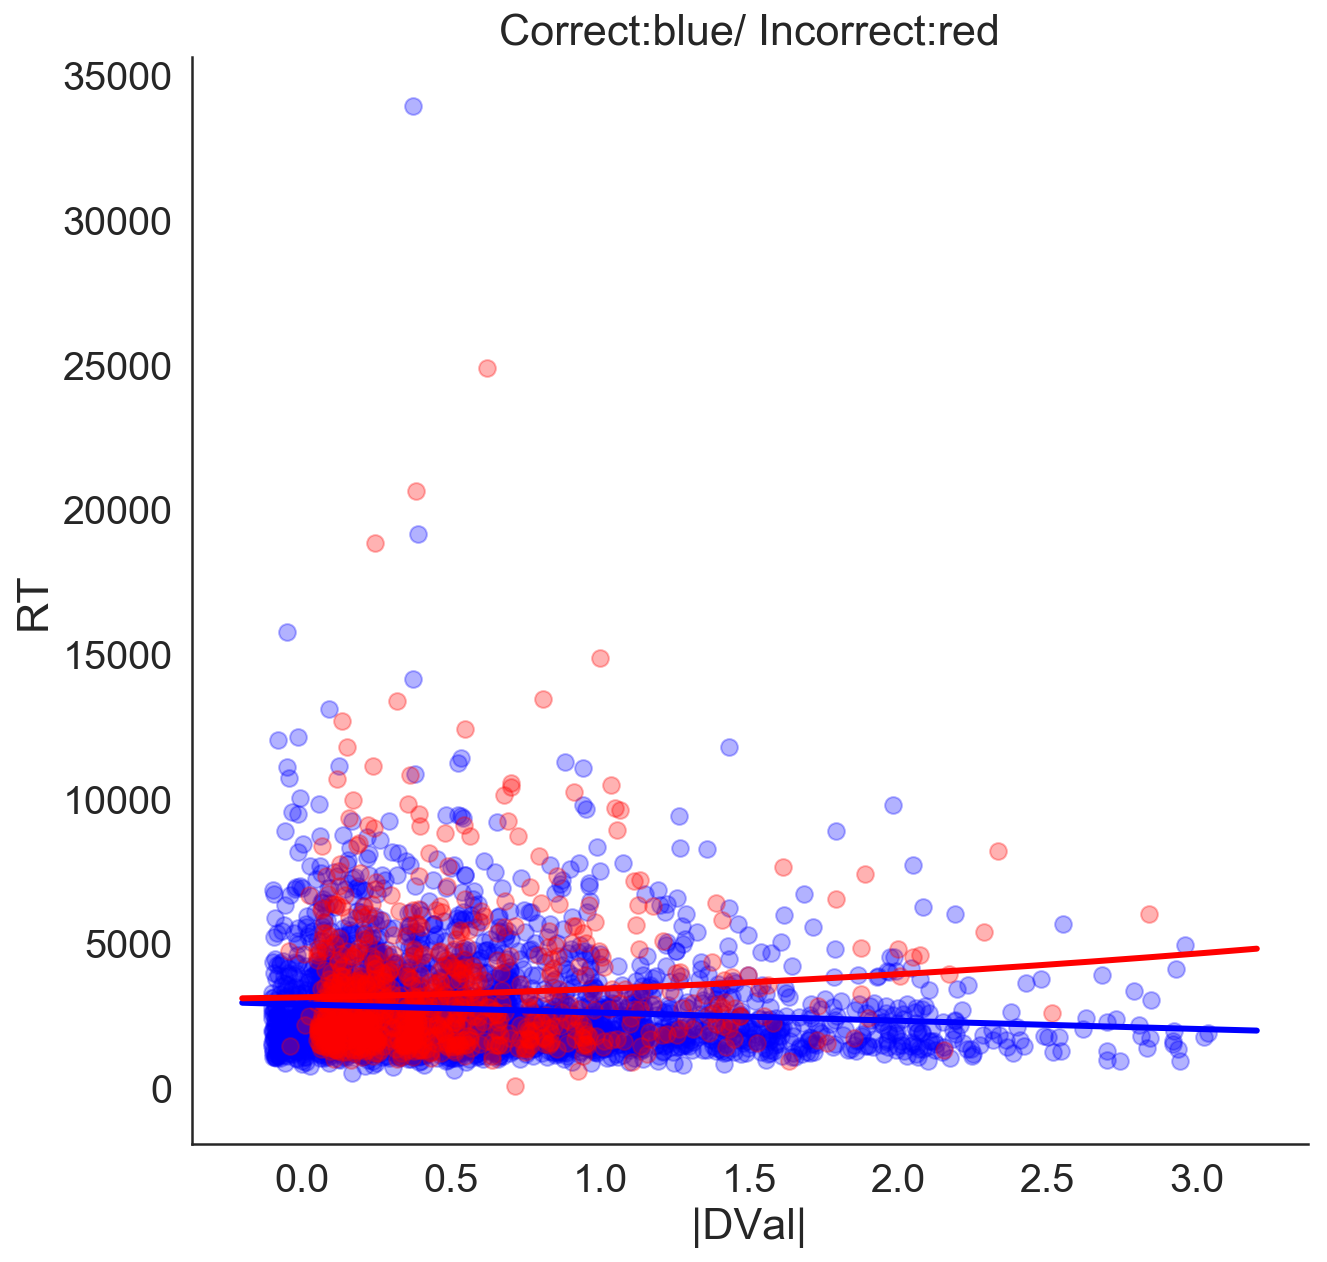

In [20]:
Correct_trials = data_all.loc[data_all['Correct'] == 1]
Incorrect_trials = data_all.loc[data_all['Correct'] == 0]
Delta_RT = Correct_trials.RT.mean() - Incorrect_trials.RT.mean()
dual_corr("Correct:blue/ Incorrect:red",'AbsDVal','RT','|DVal|','RT',Correct_trials,Incorrect_trials)

## Bin value to compare between correct and incorrect trials

In [21]:
data_all_bins_L = pd.concat([data_all.reset_index(), bin_values(data_all)], axis=1)
data_all_bins_D = pd.concat([data_all2.reset_index(), bin_values(data_all2)], axis=1)


In [22]:
#data_all_bins.to_csv("data/FF2018_data/DataFrameBinned_31.csv",index = False)

In [23]:
data_all_bins_L.columns

Index(['index', 'Part', 'TrialN', 'PairID', 'LItem', 'LVal', 'RItem', 'RVal',
       'Choice', 'RT', 'Conf', 'ConfRT', 'BlockCond', 'DDT', 'LDwellTime',
       'RDwellTime', 'GSF', 'LastFixat', 'DVal', 'zDVal', 'AbsDVal',
       'zAbsDVal', 'zConf', 'zRT', 'DFam', 'LFam', 'RFam', 'TotFam', 'TotVal',
       'ChosenFam', 'UnchosenFam', 'ChosenVal', 'UnchosenVal', 'Correct',
       'LValConfBDM', 'LFamConfBDM', 'RValConfBDM', 'RFamConfBDM', 'zDFam',
       'zTotFam', 'zTotVal', 'zChosenVal', 'zUnchosenVal', 'zChosenFam',
       'zUnchosenFam', 'zGSF', 'zDDT', 'zAbsDDT', 'zAbsDFam', 'zLVal', 'zRVal',
       'zLFam', 'zRFam', 'zLValConfBDM', 'zLFamConfBDM', 'zRValConfBDM',
       'zRFamConfBDM', 'ConfSplit', 'GSFSplit', 'DDTSplit', 'binLV', 'binRV'],
      dtype='object')

## Like 

In [24]:
data_all_bins_like = data_all_bins_L.loc[data_all_bins_L['BlockCond']== 1]
data_all_bins_like["DVbin"] = abs(data_all_bins_like["binRV"] - data_all_bins_like["binLV"])


conditions = [
    data_all_bins_like['binRV'] > data_all_bins_like['binLV'],
     data_all_bins_like['binRV'] <= data_all_bins_like['binLV'] ]
choices = [ data_all_bins_like['binRV'], data_all_bins_like['binLV']]
data_all_bins_like['DVbin_max'] = np.select(conditions, choices)

Corr_trials_bins_L = data_all_bins_like.loc[data_all_bins_like['Correct'] == 1]
Incorr_trials_bins_L = data_all_bins_like.loc[data_all_bins_like['Correct'] == 0]

## Dislike

In [25]:
data_all_bins_dislike = data_all_bins_D.loc[data_all_bins_D['BlockCond']== 2]
data_all_bins_dislike["DVbin"] = abs(data_all_bins_dislike["binRV"] - data_all_bins_dislike["binLV"])


conditions = [
    data_all_bins_dislike['binRV'] > data_all_bins_dislike['binLV'],
     data_all_bins_dislike['binRV'] <= data_all_bins_dislike['binLV'] ]
choices = [ data_all_bins_dislike['binRV'], data_all_bins_dislike['binLV']]
data_all_bins_dislike['DVbin_max'] = np.select(conditions, choices)

Corr_trials_bins_D = data_all_bins_dislike.loc[data_all_bins_dislike['Correct'] == 1]
Incorr_trials_bins_D = data_all_bins_dislike.loc[data_all_bins_dislike['Correct'] == 0]

like
Pearson's r = 0.109 p =  0.0


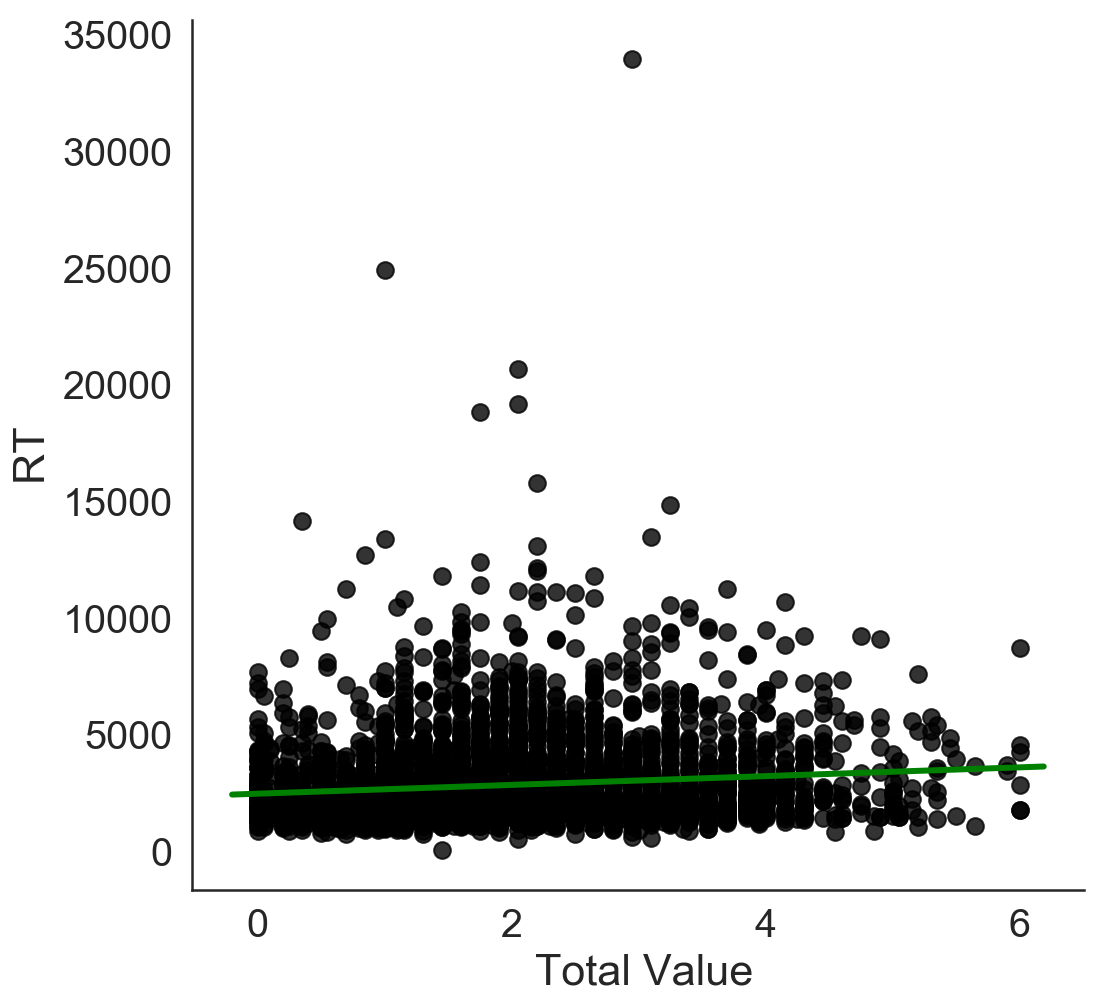

dislike
Pearson's r = 0.127 p =  0.0


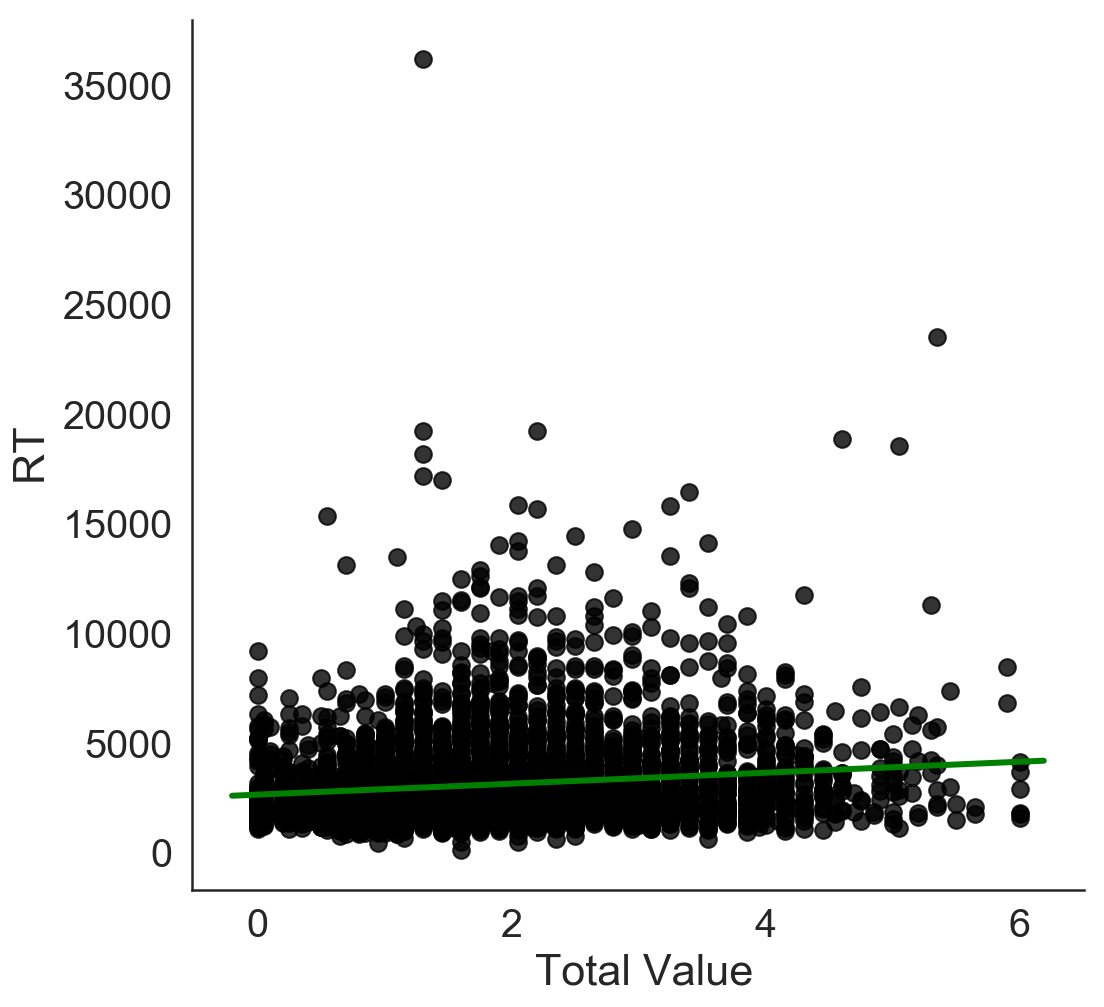

In [26]:
#Plotting   
print('like')
correl_plot(data_all_bins_like,'TotVal', " Total Value",'RT',' RT ')
print('dislike')
correl_plot(data_all_bins_dislike,'TotVal', " Total Value",'RT',' RT ')

In [27]:
%%R
library(lme4)
library(car)
library(optimx)
library(ggplot2)
library(MASS)
library(broom)
library(dplyr)
library(reshape2)
library(arm)
library(multcomp)
library(pbkrtest)

In [28]:
%R -i data_all_bins_like -i data_all_bins_dislike

/anaconda3/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


In [29]:
%%R
# Separating the data for both conditions 
data_exp1_Like <- data_all_bins_like
data_exp1_Dislike <- data_all_bins_dislike

[1] "Like BIC:"
[1] 66782.82
[1] "DisLike BIC:"
[1] 67692.51


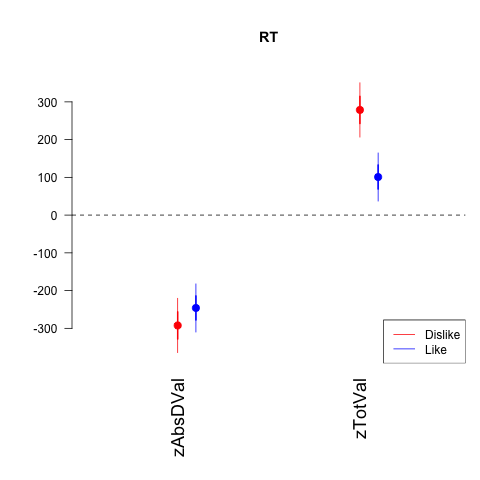

In [30]:
%%R
#regression for confidence and familiarity
title_plot = ("RT")
ModelChoiceL_Fam2 <- glm(RT ~ zAbsDVal + zTotVal , data=data_exp1_Like)
ModelChoiceD_Fam2 <- glm(RT ~ zAbsDVal + zTotVal , data=data_exp1_Dislike)

BIC1 = BIC(ModelChoiceL_Fam2)
BIC2 = BIC(ModelChoiceD_Fam2)
print("Like BIC:")
print(BIC1)
print("DisLike BIC:")
print(BIC2)

coefplot(ModelChoiceD_Fam2,intercept=FALSE, vertical = FALSE, col.pts="red", cex.var=1.5, cex.pts=2, offset = 0.05, mar = c(8,5,5,1), main=title_plot)
coefplot(ModelChoiceL_Fam2, intercept=FALSE, vertical = FALSE, add=TRUE, col.pts="blue", cex.var=1.5, cex.pts=2,mar = c(8,4,5,1),main="RegEstim")
legend("bottomright",  legend=c("Dislike", "Like"),col=c("red", "blue"), lty=1:1, cex=1)

[1] "Like BIC:"
[1] 10053.68
[1] "DisLike BIC:"
[1] 10819.43


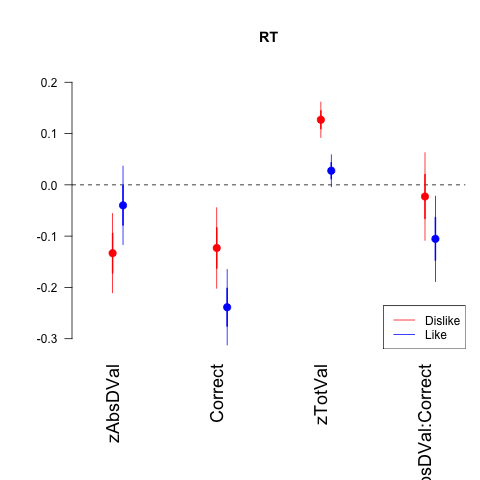

In [31]:
%%R

title_plot = ("RT")
ModelChoiceL_Fam2 <- glm(zRT ~ zAbsDVal + Correct + zTotVal + zAbsDVal : Correct , data=data_exp1_Like)
ModelChoiceD_Fam2 <- glm(zRT ~ zAbsDVal + Correct + zTotVal + zAbsDVal : Correct, data=data_exp1_Dislike)

BIC1 = BIC(ModelChoiceL_Fam2)
BIC2 = BIC(ModelChoiceD_Fam2)
print("Like BIC:")
print(BIC1)
print("DisLike BIC:")
print(BIC2)

coefplot(ModelChoiceD_Fam2,intercept=FALSE, vertical = FALSE, col.pts="red", cex.var=1.5, cex.pts=2, offset = 0.05, mar = c(8,5,5,1), ylim = c(-0.30,0.20),  main=title_plot)
coefplot(ModelChoiceL_Fam2, intercept=FALSE, vertical = FALSE, add=TRUE, col.pts="blue", cex.var=1.5, cex.pts=2,mar = c(8,4,5,1),main="RegEstim")
legend("bottomright",  legend=c("Dislike", "Like"),col=c("red", "blue"), lty=1:1, cex=1)

In regression context Mean(ValueLeft,ValueRight) is basically the same that TotVal (linear transformation). Total Value has a positive influence over reaction time in both cases (higher total value --> slower reaction time ). Marius said he expected that mean(ValueLeft,ValueRight) didn't have an effect over RT. However, in this case we are considering all the trials together. Now I proceed to separate trials with the same stimuli and compare the differences in reaction time between correct and incorrect

[1] "Like BIC:"
[1] 10059.47
[1] "DisLike BIC:"
[1] 10818.7


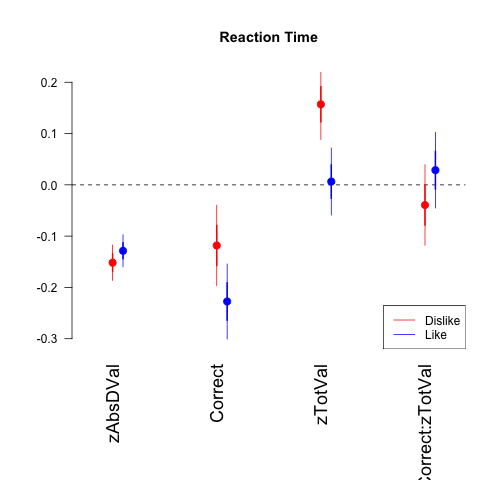

In [53]:
%%R

title_plot = ("Reaction Time")
ModelChoiceL_Fam2 <- glm(zRT ~ zAbsDVal + Correct + zTotVal + zTotVal : Correct , data=data_exp1_Like)
ModelChoiceD_Fam2 <- glm(zRT ~ zAbsDVal + Correct + zTotVal + zTotVal : Correct, data=data_exp1_Dislike)

BIC1 = BIC(ModelChoiceL_Fam2)
BIC2 = BIC(ModelChoiceD_Fam2)
print("Like BIC:")
print(BIC1)
print("DisLike BIC:")
print(BIC2)

coefplot(ModelChoiceD_Fam2,intercept=FALSE, vertical = FALSE, col.pts="red", cex.var=1.5, cex.pts=2, offset = 0.05, mar = c(8,5,5,1), ylim = c(-0.30,0.20),  main=title_plot)
coefplot(ModelChoiceL_Fam2, intercept=FALSE, vertical = FALSE, add=TRUE, col.pts="blue", cex.var=1.5, cex.pts=2,mar = c(8,4,5,1),main="RegEstim")
legend("bottomright",  legend=c("Dislike", "Like"),col=c("red", "blue"), lty=1:1, cex=1)

# Compare Correct and Incorrect reaction times. 
## Averaging in trials with the same stimuli. 

## Considering Like frame

In [33]:
meanRTc = []
meanRTi = []
DVal = []
TotVal = []
matrix_aux = []
matrix = []

for j in range(0,6): # DV range
    Corr_trials_bins_separate1 = Corr_trials_bins_L.loc[Corr_trials_bins_L['DVbin']== j]
    Incorr_trials_bins_separate1 = Incorr_trials_bins_L.loc[Incorr_trials_bins_L['DVbin']== j]
    if (len(Incorr_trials_bins_separate1) == 0 ) or (len(Corr_trials_bins_separate1) == 0) :
        continue
        
    for i in range(0,6): # MaxVal range
        Corr_trials_bins_separate1_maxs = Corr_trials_bins_separate1.loc[Corr_trials_bins_separate1['DVbin_max']== i]
        Incorr_trials_bins_separate1_maxs = Incorr_trials_bins_separate1.loc[Incorr_trials_bins_separate1['DVbin_max']== i]
        if (len(Corr_trials_bins_separate1_maxs) == 0) or (len(Incorr_trials_bins_separate1_maxs) == 0):
            continue
        #RT_distribut(Corr_trials_bins_separate1_maxs,Incorr_trials_bins_separate1_maxs)
    
        meanRTc = Corr_trials_bins_separate1_maxs.RT.mean()
        meanRTi = Incorr_trials_bins_separate1_maxs.RT.mean()
        DeltaRT = -Corr_trials_bins_separate1_maxs.RT.mean() + Incorr_trials_bins_separate1_maxs.RT.mean()
        DVal = Incorr_trials_bins_separate1_maxs.DVbin.mean()
        TotVal = Incorr_trials_bins_separate1_maxs.binLV.mean() + Incorr_trials_bins_separate1_maxs.binRV.mean()
        MeanVal = (Incorr_trials_bins_separate1_maxs.binLV.mean() + Incorr_trials_bins_separate1_maxs.binRV.mean())/2
        matrix_aux= np.column_stack((DVal,TotVal,MeanVal,meanRTc,meanRTi,DeltaRT))
        
        
        for j in range(len(matrix_aux)):   
            matrix.append(matrix_aux[j])
        
matrix = pd.DataFrame(matrix,columns=['DVal','TotVal','MeanVal','RTc','RTi','DRT',])

In [34]:
matrix

,DVal,TotVal,MeanVal,RTc,RTi,DRT
0,0.0,0.0,0.0,2687.851562,3274.960000,587.108438
1,0.0,2.0,1.0,2514.083871,3157.187500,643.103629
2,0.0,4.0,2.0,2944.956522,3772.128205,827.171683
3,0.0,6.0,3.0,3649.559322,3995.115385,345.556063
4,0.0,8.0,4.0,2783.428571,2856.521739,73.093168
5,0.0,10.0,5.0,2628.632653,2375.571429,-253.061224
6,1.0,1.0,0.5,3052.162162,3097.593750,45.431588
7,1.0,3.0,1.5,2789.273224,3227.060606,437.787382
8,1.0,5.0,2.5,2990.041096,3508.319588,518.278492
9,1.0,7.0,3.5,3025.400000,3378.894737,353.494737


/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,0,'RT')

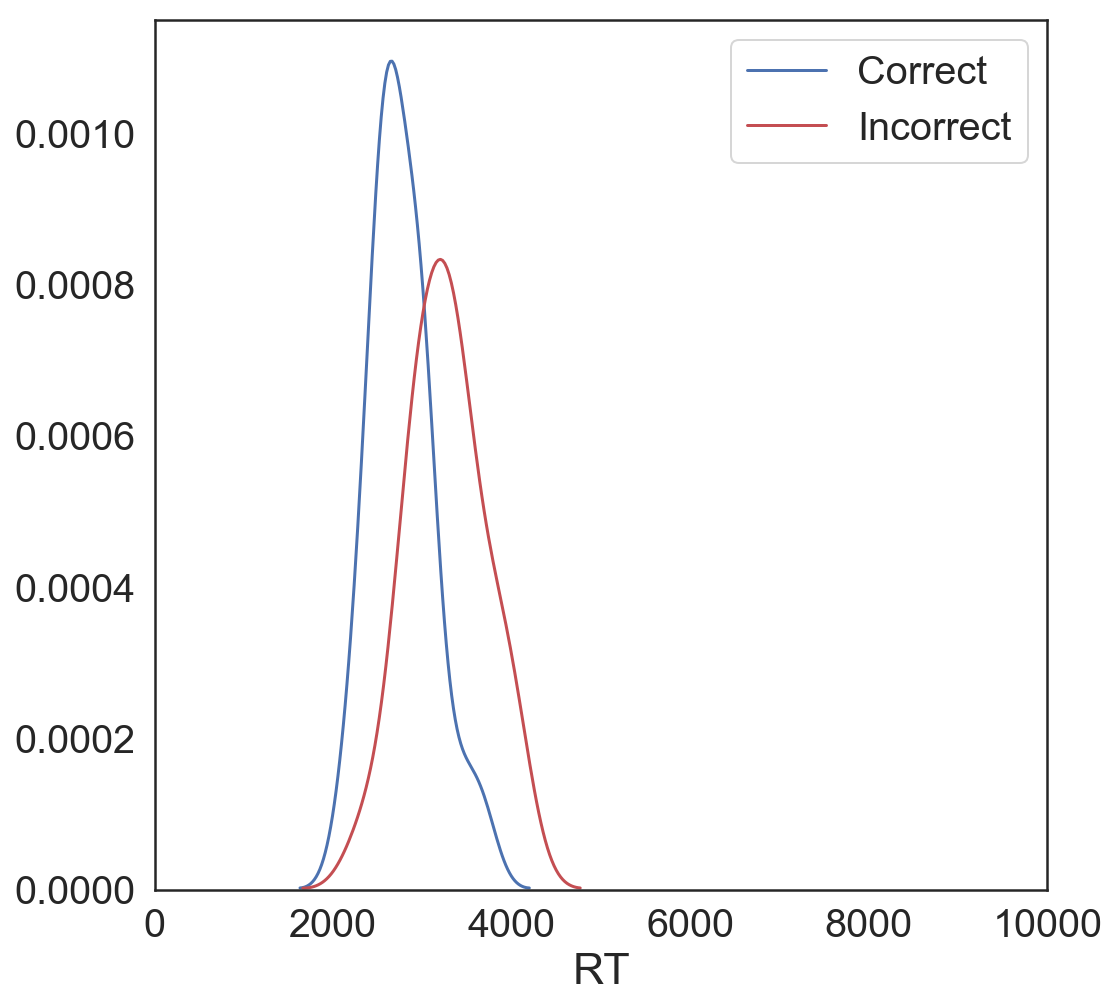

In [35]:
f = plt.figure(figsize=(8, 8))
sns.set(style='white', font_scale=1.8)
ax1 = sns.distplot(matrix.RTc, bins=30, rug=False, hist = False, color = 'b',label = 'Correct');
ax2 = sns.distplot(matrix.RTi, bins=30, rug=False, hist = False, color = 'r',label = 'Incorrect');
plt.xlim(0, 10000)
plt.xlabel('RT')

Pearson's r = 0.422 p =  0.056


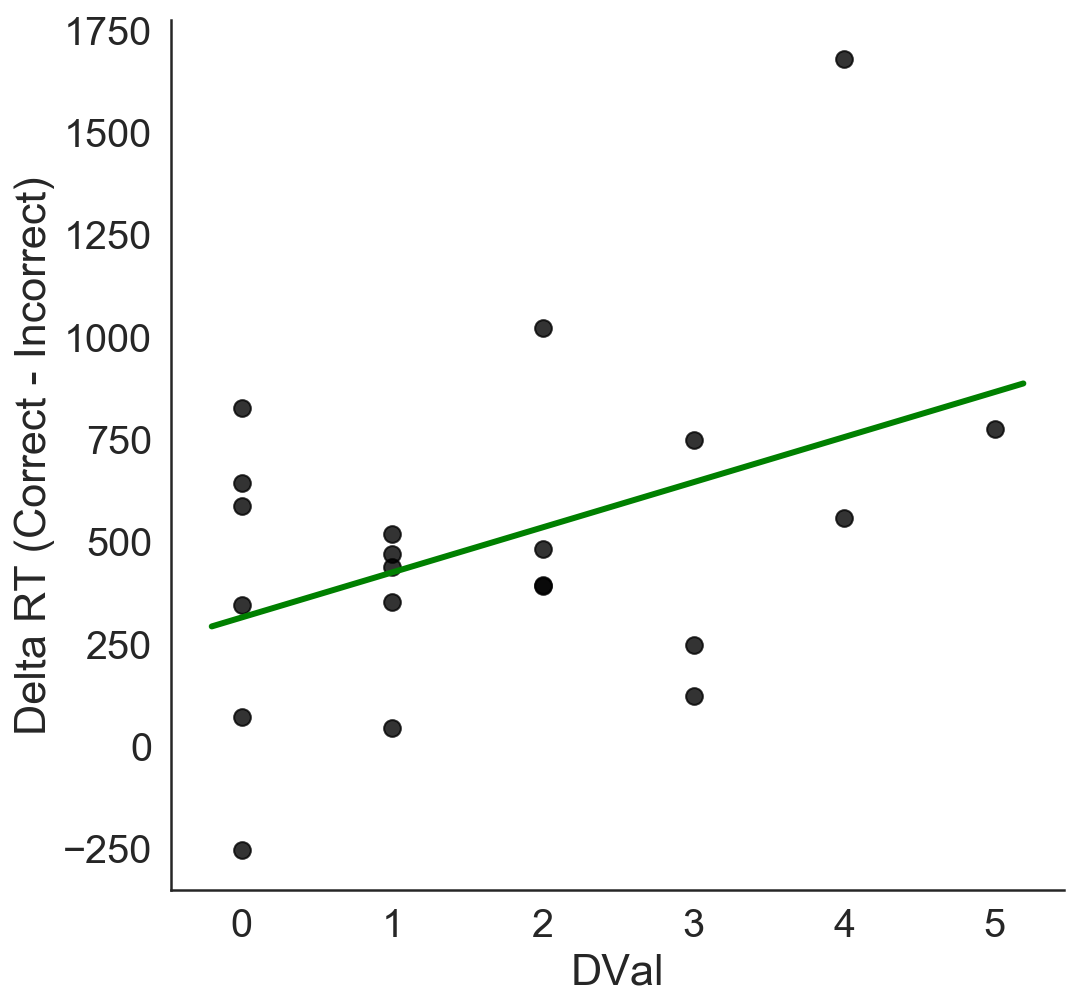

In [36]:
#Plotting   

correl_plot(matrix,'DVal', "DVal",'DRT','Delta RT (Correct - Incorrect)')

Pearson's r = -0.315 p =  0.165


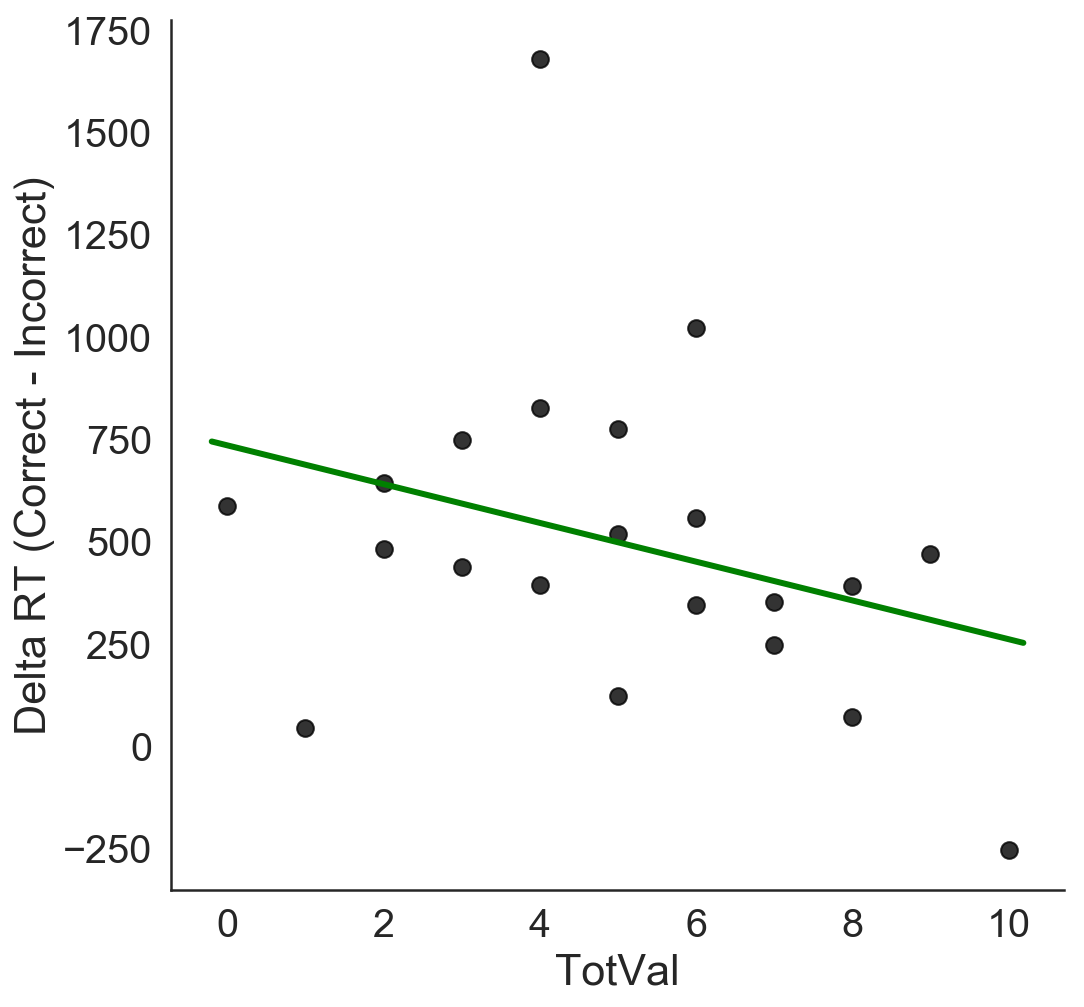

In [37]:
#Plotting   

correl_plot(matrix,'TotVal', "TotVal",'DRT','Delta RT (Correct - Incorrect)')

* Not significant correlation between Total Value and Delta RT

Pearson's r = -0.315 p =  0.165


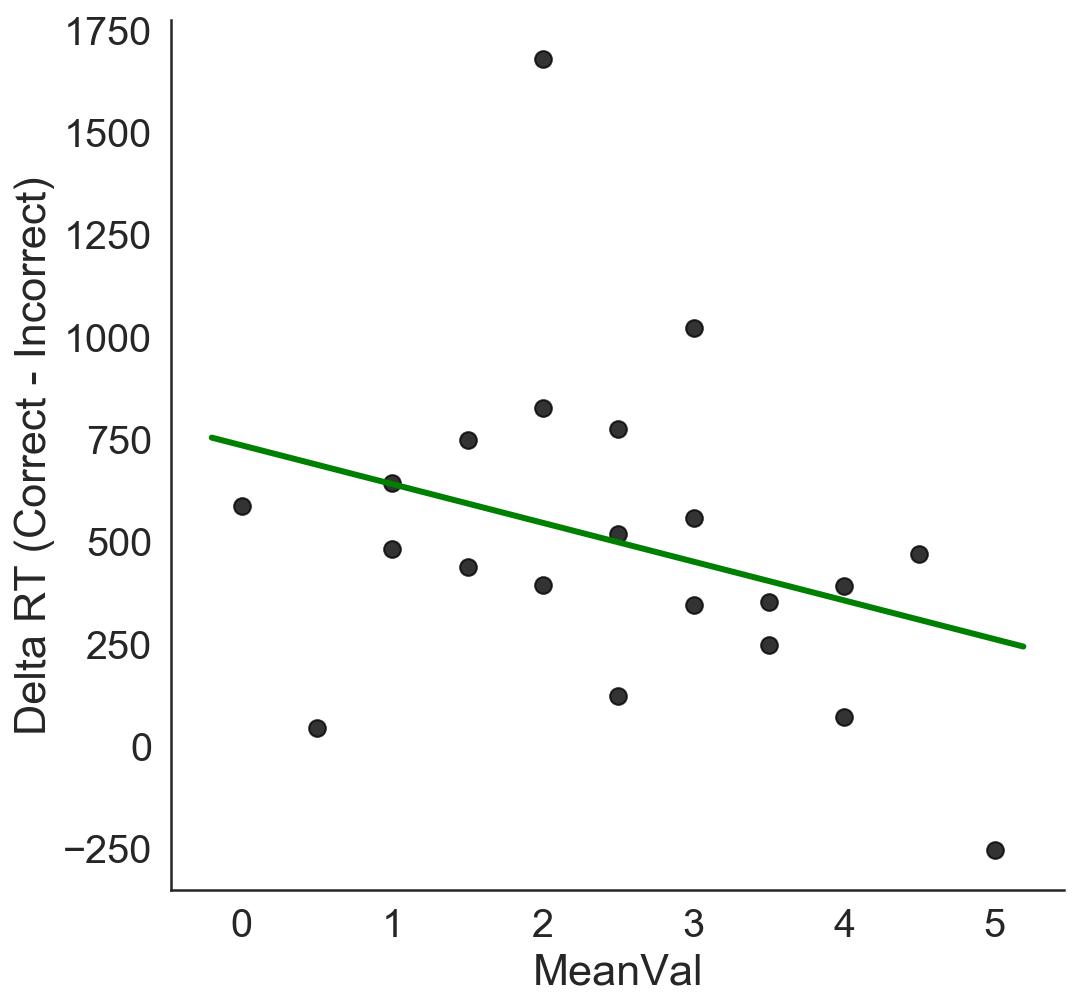

In [38]:
#Plotting   

correl_plot(matrix,'MeanVal', "MeanVal",'DRT','Delta RT (Correct - Incorrect)')

In [39]:
%%R -i matrix
datas  <- matrix

/anaconda3/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


BIC: 315.3816
Call:  glm(formula = DRT ~ +TotVal + DVal, data = datas)

Coefficients:
(Intercept)       TotVal         DVal  
     551.95       -47.34       110.12  

Degrees of Freedom: 20 Total (i.e. Null);  18 Residual
Null Deviance:	    3172000 
Residual Deviance: 2292000 	AIC: 311.2


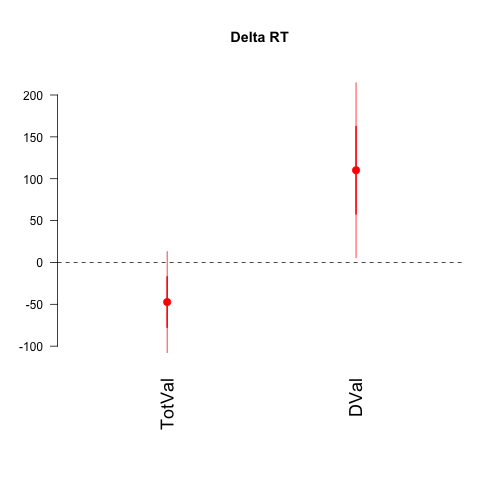

In [40]:
%%R
title_plot = " Delta RT  "
ModelCorrect_1 <- glm(DRT ~ + TotVal +DVal , data= datas)
coefplot(ModelCorrect_1,intercept=FALSE,vertical = FALSE,  col.pts="red", cex.var=1.5, cex.pts=2, mar = c(8,4,5,1),main=title_plot)
#legend("topright",  legend=c("Dislike", "Like"),col=c("red", "blue"), lty=1:1, cex=1)
BICc1 = BIC(ModelCorrect_1)
cat("BIC:" , BICc1)
ModelCorrect_1

BIC: 305.3598
Call:  glm(formula = RTc ~ +TotVal + DVal, data = datas)

Coefficients:
(Intercept)       TotVal         DVal  
    2871.83        26.11      -138.73  

Degrees of Freedom: 20 Total (i.e. Null);  18 Residual
Null Deviance:	    2416000 
Residual Deviance: 1422000 	AIC: 301.2


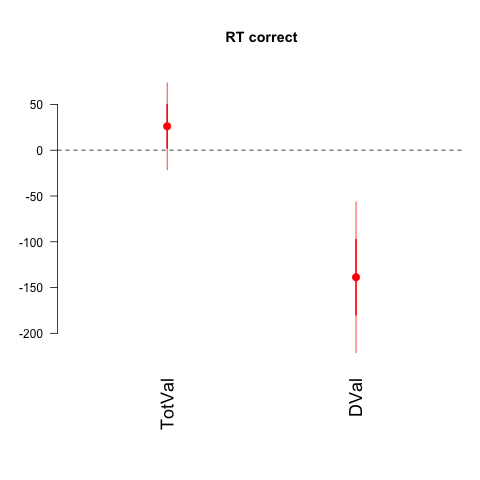

In [41]:
%%R
title_plot = "  RT correct  "
ModelCorrect_1 <- glm(RTc ~ + TotVal +DVal , data= datas)
coefplot(ModelCorrect_1,intercept=FALSE,vertical = FALSE,  col.pts="red", cex.var=1.5, cex.pts=2, mar = c(8,4,5,1),main=title_plot)
#legend("topright",  legend=c("Dislike", "Like"),col=c("red", "blue"), lty=1:1, cex=1)
BICc1 = BIC(ModelCorrect_1)
cat("BIC:" , BICc1)
ModelCorrect_1

BIC: 324.6076
Call:  glm(formula = RTi ~ +TotVal + DVal, data = datas)

Coefficients:
(Intercept)       TotVal         DVal  
    3423.79       -21.24       -28.62  

Degrees of Freedom: 20 Total (i.e. Null);  18 Residual
Null Deviance:	    3658000 
Residual Deviance: 3556000 	AIC: 320.4


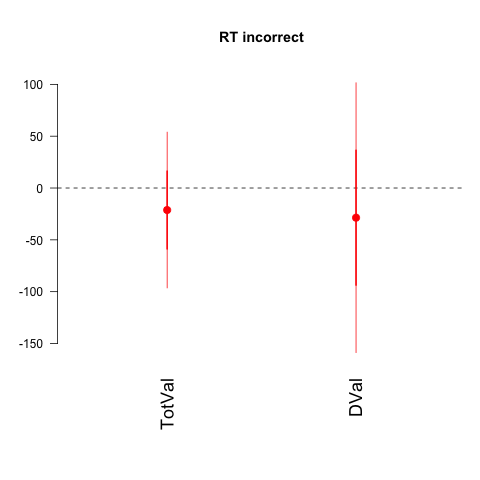

In [42]:
%%R
title_plot = "  RT incorrect  "
ModelCorrect_1 <- glm(RTi ~ + TotVal +DVal , data= datas)
coefplot(ModelCorrect_1,intercept=FALSE,vertical = FALSE,  col.pts="red", cex.var=1.5, cex.pts=2, mar = c(8,4,5,1),main=title_plot)
#legend("topright",  legend=c("Dislike", "Like"),col=c("red", "blue"), lty=1:1, cex=1)
BICc1 = BIC(ModelCorrect_1)
cat("BIC:" , BICc1)
ModelCorrect_1

Separating between correct incorrect and after taking averages for trials with the same stimuli we don't appreciate an influence of Total Value over RT.

# Dislike frame

In [43]:
meanRTc = []
meanRTi = []
DVal = []
TotVal = []
matrix_aux = []
matrix = []

for j in range(0,6): # DV range
    Corr_trials_bins_separate1 = Corr_trials_bins_D.loc[Corr_trials_bins_D['DVbin']== j]
    Incorr_trials_bins_separate1 = Incorr_trials_bins_D.loc[Incorr_trials_bins_D['DVbin']== j]
    if (len(Incorr_trials_bins_separate1) == 0 ) or (len(Corr_trials_bins_separate1) == 0) :
        continue
        
    for i in range(0,6): # MaxVal range
        Corr_trials_bins_separate1_maxs = Corr_trials_bins_separate1.loc[Corr_trials_bins_separate1['DVbin_max']== i]
        Incorr_trials_bins_separate1_maxs = Incorr_trials_bins_separate1.loc[Incorr_trials_bins_separate1['DVbin_max']== i]
        if (len(Corr_trials_bins_separate1_maxs) == 0) or (len(Incorr_trials_bins_separate1_maxs) == 0):
            continue
        #RT_distribut(Corr_trials_bins_separate1_maxs,Incorr_trials_bins_separate1_maxs)
    
        meanRTc = Corr_trials_bins_separate1_maxs.RT.mean()
        meanRTi = Incorr_trials_bins_separate1_maxs.RT.mean()
        DeltaRT = -Corr_trials_bins_separate1_maxs.RT.mean() + Incorr_trials_bins_separate1_maxs.RT.mean()
        DVal = Incorr_trials_bins_separate1_maxs.DVbin.mean()
        TotVal = Incorr_trials_bins_separate1_maxs.binLV.mean() + Incorr_trials_bins_separate1_maxs.binRV.mean()
        MeanVal = (Incorr_trials_bins_separate1_maxs.binLV.mean() + Incorr_trials_bins_separate1_maxs.binRV.mean())/2
        matrix_aux= np.column_stack((DVal,TotVal,MeanVal,meanRTc,meanRTi,DeltaRT))
        
        
        for j in range(len(matrix_aux)):   
            matrix.append(matrix_aux[j])
        
matrix = pd.DataFrame(matrix,columns=['DVal','TotVal','MeanVal','RTc','RTi','DRT',])

In [44]:
matrix

,DVal,TotVal,MeanVal,RTc,RTi,DRT
0,0.0,0.0,0.0,2637.388430,2843.766667,206.378237
1,0.0,2.0,1.0,2913.290323,3608.000000,694.709677
2,0.0,4.0,2.0,3449.679144,2951.400000,-498.279144
3,0.0,6.0,3.0,3587.981982,3949.812500,361.830518
4,0.0,8.0,4.0,3291.806452,4461.391304,1169.584853
5,0.0,10.0,5.0,3289.340206,3453.619048,164.278841
6,1.0,1.0,0.5,2659.716216,4101.000000,1441.283784
7,1.0,3.0,1.5,2937.738889,3359.681159,421.942271
8,1.0,5.0,2.5,3071.852941,3113.355769,41.502828
9,1.0,7.0,3.5,3497.188034,4199.769231,702.581197


/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,0,'RT')

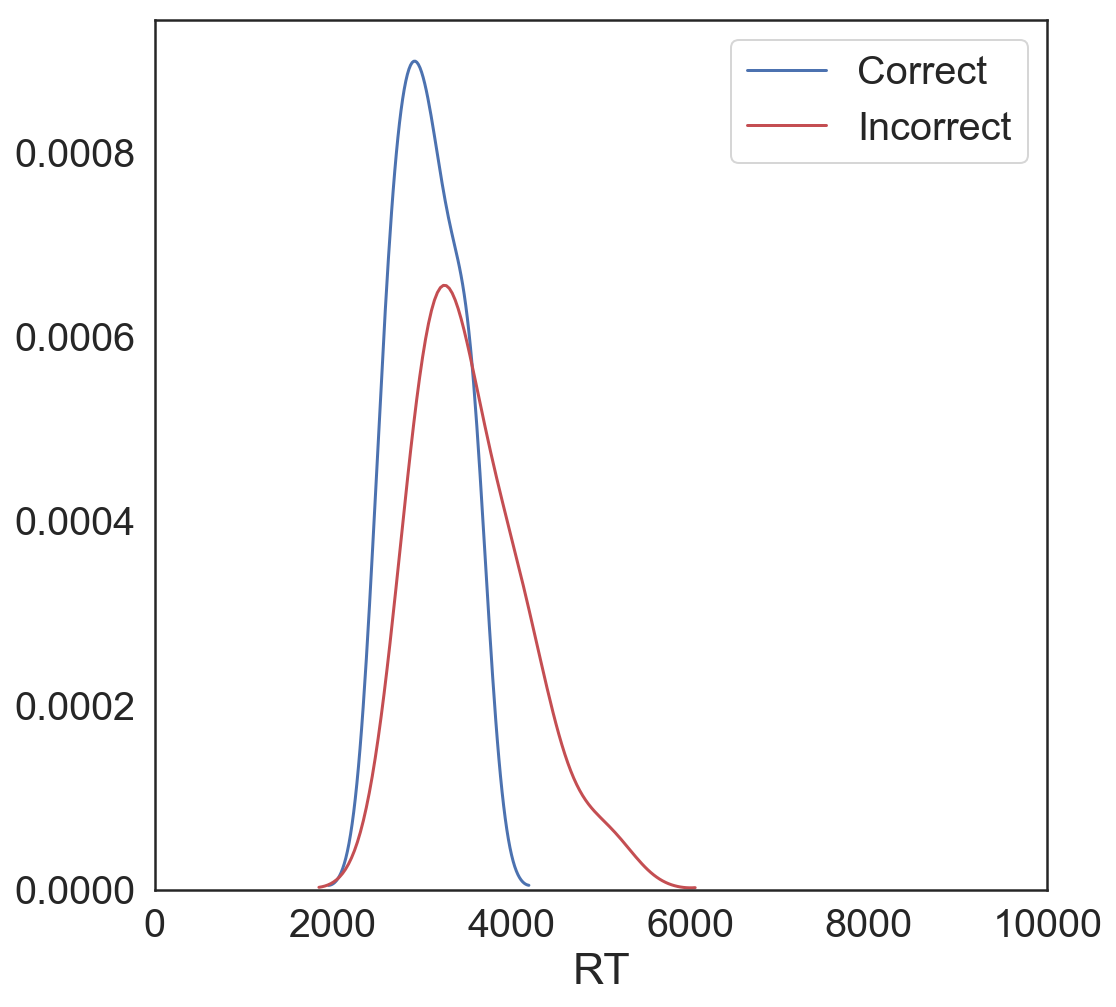

In [45]:
f = plt.figure(figsize=(8, 8))
sns.set(style='white', font_scale=1.8)
ax1 = sns.distplot(matrix.RTc, bins=30, rug=False, hist = False, color = 'b',label = 'Correct');
ax2 = sns.distplot(matrix.RTi, bins=30, rug=False, hist = False, color = 'r',label = 'Incorrect');
plt.xlim(0, 10000)
plt.xlabel('RT')

Pearson's r = -0.048 p =  0.836


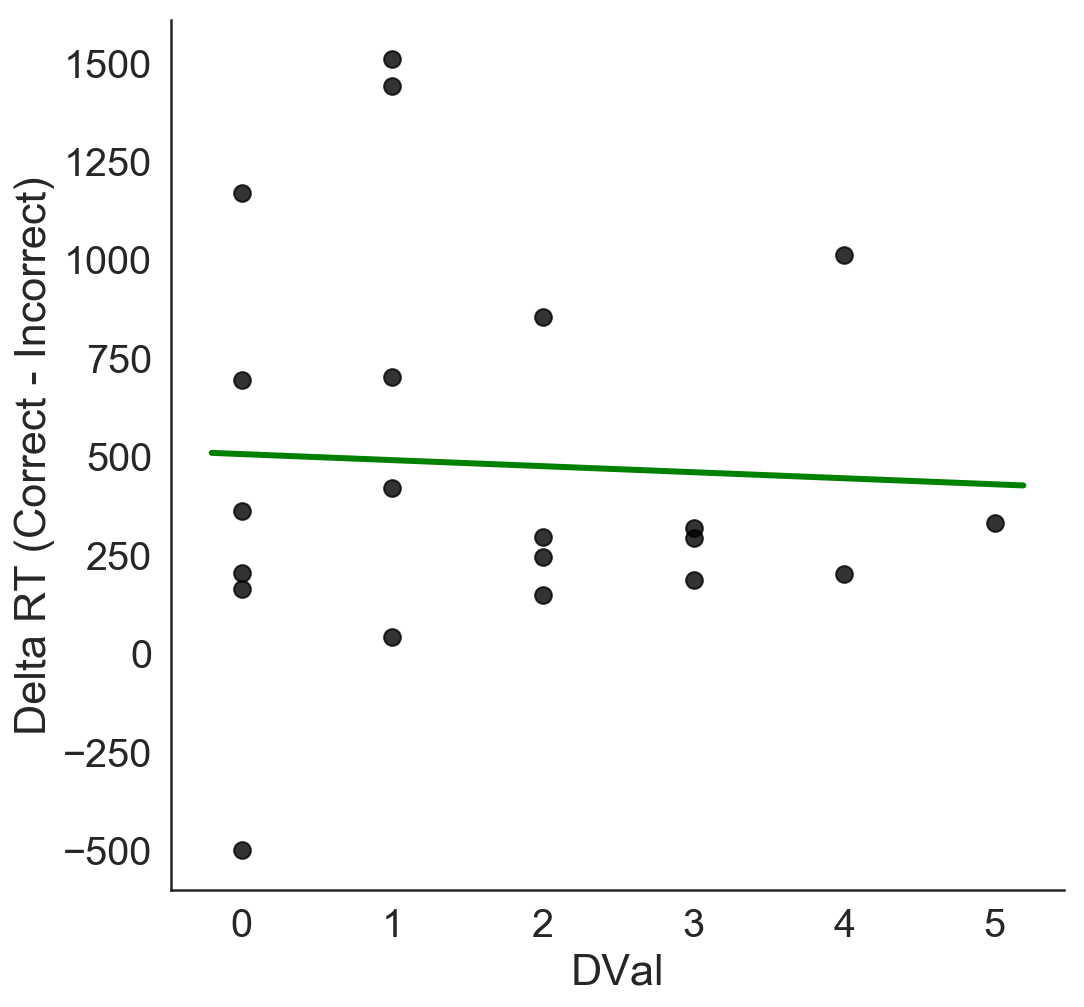

In [46]:
#Plotting   

correl_plot(matrix,'DVal', "DVal",'DRT','Delta RT (Correct - Incorrect)')

Pearson's r = 0.14 p =  0.545


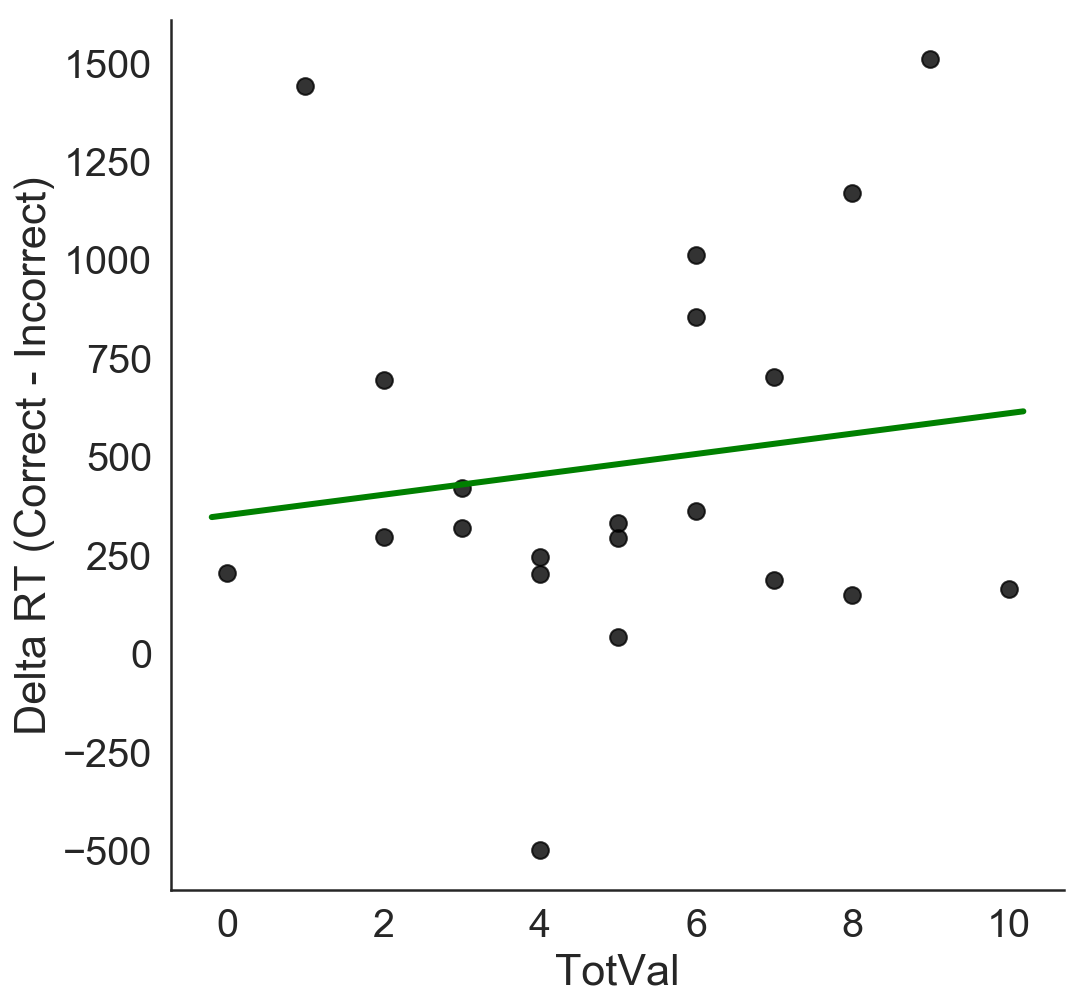

In [47]:
#Plotting   

correl_plot(matrix,'TotVal', "TotVal",'DRT','Delta RT (Correct - Incorrect)')

* Not significant correlation between Total Value and Delta RT

Pearson's r = 0.14 p =  0.545


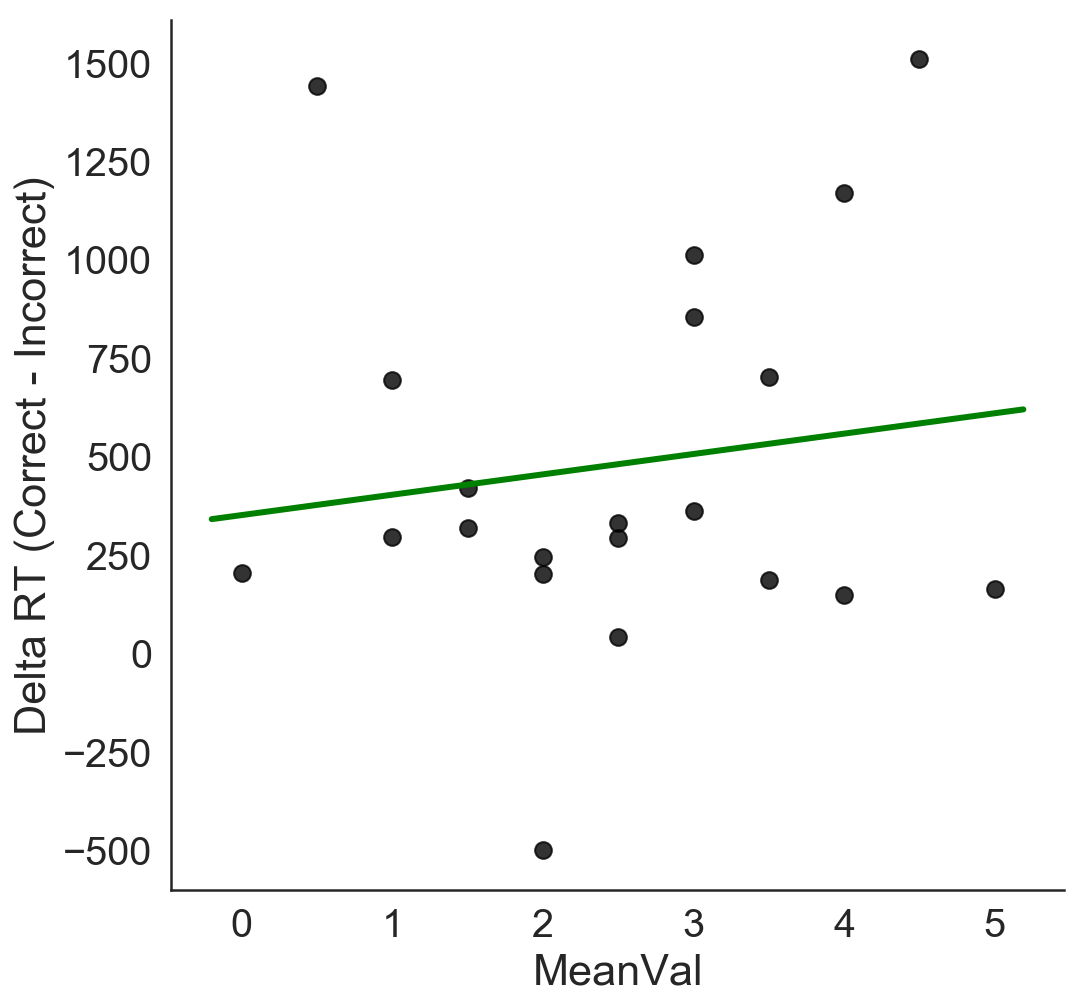

In [48]:
#Plotting   

correl_plot(matrix,'MeanVal', "MeanVal",'DRT','Delta RT (Correct - Incorrect)')

In [49]:
%%R -i matrix
datas  <- matrix

/anaconda3/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


BIC: 330.2697
Call:  glm(formula = DRT ~ +TotVal + DVal, data = datas)

Coefficients:
(Intercept)       TotVal         DVal  
     377.78        25.85       -15.34  

Degrees of Freedom: 20 Total (i.e. Null);  18 Residual
Null Deviance:	    4761000 
Residual Deviance: 4657000 	AIC: 326.1


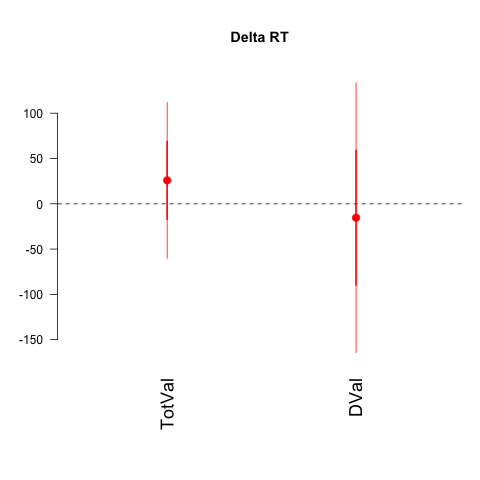

In [50]:
%%R
title_plot = " Delta RT  "
ModelCorrect_1 <- glm(DRT ~ + TotVal +DVal , data= datas)
coefplot(ModelCorrect_1,intercept=FALSE,vertical = FALSE,  col.pts="red", cex.var=1.5, cex.pts=2, mar = c(8,4,5,1),main=title_plot)
#legend("topright",  legend=c("Dislike", "Like"),col=c("red", "blue"), lty=1:1, cex=1)
BICc1 = BIC(ModelCorrect_1)
cat("BIC:" , BICc1)
ModelCorrect_1

BIC: 291.3859
Call:  glm(formula = RTc ~ +TotVal + DVal, data = datas)

Coefficients:
(Intercept)       TotVal         DVal  
    2836.18        84.84      -123.34  

Degrees of Freedom: 20 Total (i.e. Null);  18 Residual
Null Deviance:	    2449000 
Residual Deviance: 731100 	AIC: 287.2


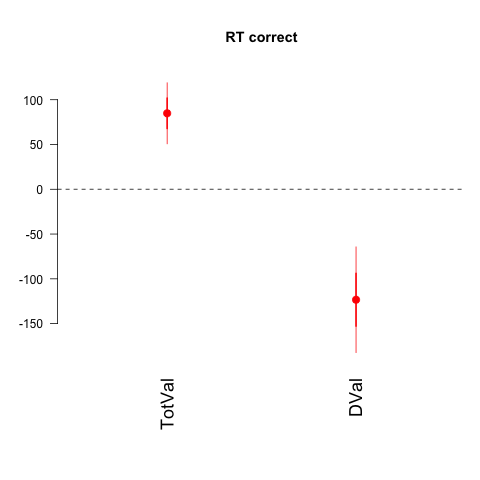

In [51]:
%%R
title_plot = "  RT correct  "
ModelCorrect_1 <- glm(RTc ~ + TotVal +DVal , data= datas)
coefplot(ModelCorrect_1,intercept=FALSE,vertical = FALSE,  col.pts="red", cex.var=1.5, cex.pts=2, mar = c(8,4,5,1),main=title_plot)
#legend("topright",  legend=c("Dislike", "Like"),col=c("red", "blue"), lty=1:1, cex=1)
BICc1 = BIC(ModelCorrect_1)
cat("BIC:" , BICc1)
ModelCorrect_1

BIC: 327.7955
Call:  glm(formula = RTi ~ +TotVal + DVal, data = datas)

Coefficients:
(Intercept)       TotVal         DVal  
     3214.0        110.7       -138.7  

Degrees of Freedom: 20 Total (i.e. Null);  18 Residual
Null Deviance:	    6752000 
Residual Deviance: 4139000 	AIC: 323.6


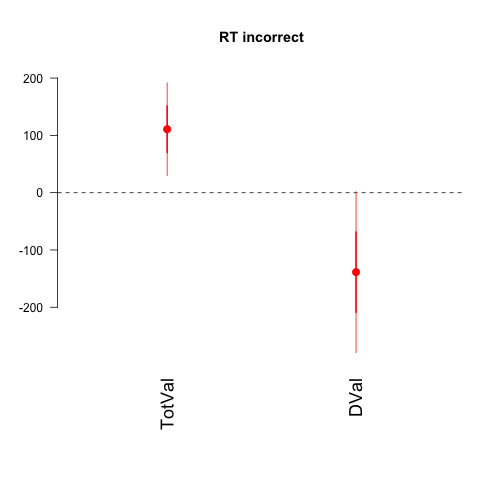

In [52]:
%%R
title_plot = "  RT incorrect  "
ModelCorrect_1 <- glm(RTi ~ + TotVal +DVal , data= datas)
coefplot(ModelCorrect_1,intercept=FALSE,vertical = FALSE,  col.pts="red", cex.var=1.5, cex.pts=2, mar = c(8,4,5,1),main=title_plot)
#legend("topright",  legend=c("Dislike", "Like"),col=c("red", "blue"), lty=1:1, cex=1)
BICc1 = BIC(ModelCorrect_1)
cat("BIC:" , BICc1)
ModelCorrect_1

In Dislike separating between correct incorrect and after taking averages for trials with the same stimuli we don't appreciate an influence of Total Value over RT.